In [1]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# hyper parameters
input_size = 4
num_classes = 3
num_epochs = 10000
learning_rate = 0.01

Irisデータセットは特徴量が4つ（sepal length、sepal width、petal length、petal width）なので入力ユニット数は4にした。またクラス数が3つ（Setosa、Versicolour、Virginica）なので出力ユニット数は3にした。

In [3]:
iris = load_iris()
X = iris.data
y = iris.target
print(X.shape)
print(y.shape)

(150, 4)
(150,)


データのロードはscikit-learnのload_iris()関数で簡単にできる。辞書で返ってくるが ``data`` でデータ本体が ``target`` でクラスラベルが取得できる。**クラスラベルは1-of-Kになっていないので注意！<br>PyTorchはクラスラベルを自分で one-hot-encoding に変換しなくてもクラスラベルのまま扱える。**

In [5]:
# 訓練データとバリデーションデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(100, 4)
(50, 4)
(100,)
(50,)


In [7]:
# データの標準化
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(np.mean(X_train, axis=0))
print(np.std(X_train, axis=0))

[-4.66293670e-17 -2.11289319e-17  3.99680289e-17 -1.77635684e-17]
[1. 1. 1. 1.]


データの各特徴量ごとに平均0、標準偏差1になるようにデータを標準化する。Irisデータでは標準化しなくても学習はできたけどやったほうが学習が安定すると思う。``print`` してみると4つの特徴量それぞれで平均が0、標準偏差が1になってるのがわかる。

In [8]:
class LogisticRegression(nn.Module):
    
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, x):
        out = self.linear(x)
        return out

ロジスティック回帰モデルの定義。見た目は線形回帰のときとまったく同じ。実際、多クラスのロジスティック回帰は ```linear``` を通したあとに ```softmax``` を通すのだがPyTorchはモデルには含めないでロジットをそのまま返すのが流儀のようだ。**なぜかというと損失関数を計算する ```torch.nn.CrossEntropyLoss``` の中に ```softmax``` の計算が含まれている**ため。

なぜこんな仕様なのか？と思って調べてみたら **```softmax``` が必要なのは訓練時の損失計算のときだけで、推論時には必要ないので入れない方が効率がよい**とのこと。推論時はそもそも ```softmax``` を通してわざわざ確率にしなくてもロジットのまま大小比較ができるためだ。

[Why does CrossEntropyLoss include the softmax function? - PyTorch Forums](https://discuss.pytorch.org/t/why-does-crossentropyloss-include-the-softmax-function/4420)


In [9]:
model = LogisticRegression(input_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

確認のためnn.CrossEntropyLoss() のソースコードを見てみると softmax がちゃんと含まれているのが確認できる。

In [10]:
def cross_entropy(input, target, weight=None, size_average=True, ignore_index=-100, reduce=True):
    return nll_loss(log_softmax(input, 1), target, weight, size_average, ignore_index, reduce)

In [11]:
def train(X_train, y_train):
    inputs = torch.from_numpy(X_train).float()
    targets = torch.from_numpy(y_train).long()
    
    optimizer.zero_grad()
    outputs = model(inputs)
    
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()
    
    return loss.item()

def valid(X_test, y_test):
    inputs = torch.from_numpy(X_test).float()
    targets = torch.from_numpy(y_test).long()

    outputs = model(inputs)
    val_loss = criterion(outputs, targets)
    
    # 精度を求める
    _, predicted = torch.max(outputs, 1)
    correct = (predicted == targets).sum().item()
    val_acc = float(correct) / targets.size(0)

    return val_loss.item(), val_acc

loss_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(num_epochs):
    perm = np.arange(X_train.shape[0])
    np.random.shuffle(perm)
    X_train = X_train[perm]
    y_train = y_train[perm]
    
    loss = train(X_train, y_train)
    val_loss, val_acc = valid(X_test, y_test)
    
    if epoch % 1000 == 0:
        print('epoch %d, loss: %.4f val_loss: %.4f val_acc: %.4f'
              % (epoch, loss, val_loss, val_acc))
    
    # logging
    loss_list.append(loss)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

epoch 0, loss: 1.5633 val_loss: 1.6034 val_acc: 0.1400
epoch 1000, loss: 0.3185 val_loss: 0.3051 val_acc: 0.9000
epoch 2000, loss: 0.2549 val_loss: 0.2400 val_acc: 0.9000
epoch 3000, loss: 0.2185 val_loss: 0.1999 val_acc: 0.9400
epoch 4000, loss: 0.1935 val_loss: 0.1724 val_acc: 0.9600
epoch 5000, loss: 0.1752 val_loss: 0.1525 val_acc: 0.9800
epoch 6000, loss: 0.1611 val_loss: 0.1377 val_acc: 0.9800
epoch 7000, loss: 0.1500 val_loss: 0.1262 val_acc: 0.9800
epoch 8000, loss: 0.1410 val_loss: 0.1172 val_acc: 0.9800
epoch 9000, loss: 0.1334 val_loss: 0.1099 val_acc: 0.9800


いくつか注意点

- エポックごとにデータをシャッフルする
- PyTorchではデータは FloatTensor でラベルは LongTensor にする必要がある。Irisデータの特徴量は float64 (double) 型になっているため テンソルを float() でキャストする必要がある。ラベルはもともと int64 (long) 型なのでキャストは不要だったが念のため long() でキャスト
- criterion = nn.CrossEntropyLoss に渡す正解ラベルは **one-hotにする必要がない！** 0, 1, 2, 3というラベルのカテゴリのまま渡せる
最後にlossとaccのグラフ描くとこんな感じできれいに学習できているのが確認できた。

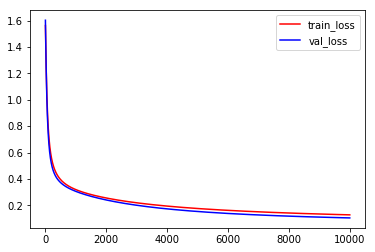

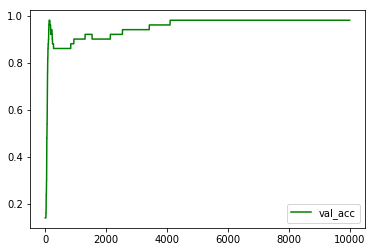

In [12]:
# plot learning curve
plt.figure()
plt.plot(range(num_epochs), loss_list, 'r-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, 'b-', label='val_loss')
plt.legend()

plt.figure()
plt.plot(range(num_epochs), val_acc_list, 'g-', label='val_acc')
plt.legend()